# Tunneling experiments 
## Boundary evolution and ants' location

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import interpolate
# Plot style
plt.rcParams.update({'font.size': 22})
rc = {"font.family" : "serif",
      "mathtext.fontset" : "cm"}
#      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Latin Modern Sans"] + plt.rcParams["font.serif"]
# For reading files and images
import h5py
from matplotlib.pyplot import cm
from statsmodels.graphics.tsaplots import plot_acf
import cv2
import os

import natsort
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

import collections
import pandas as pd

from scipy.fftpack import fft, dct, ifft, idct
from skimage.color import rgb2gray

from scipy.stats import chi2, loglaplace
from labellines import labelLine, labelLines

from scipy import ndimage

import tikzplotlib

## Function definitions

In [6]:
def load_png(folder):
    images = []
    ll = os.listdir(folder)
    ll = natsort.natsorted(ll)
    for filename in ll:
        if filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

In [7]:
def load_jpg(folder):
    images = []
    ll = os.listdir(folder)
    ll = natsort.natsorted(ll)
    for filename in ll:
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

In [8]:
def fitFunc(x, a, b):
    return a*x+b

## Radial distribution function

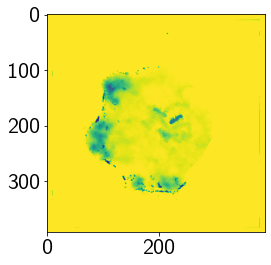

In [34]:
densImg = load_png('./')
plt.imshow(densImg[2])

In [33]:
ind = 2
xcen = int(np.shape(densImg[ind])[0]*0.5)
ycen = int(np.shape(densImg[ind])[1]*0.5)
print(xcen,ycen,np.shape(densImg[ind]))
plt.plot(densImg[ind][0:xcen][ycen])

195 195 (391, 391)


IndexError: index 195 is out of bounds for axis 0 with size 195

In [ ]:
nDiv = 100
ang = np.linspace(0,2*pi,nDiv)

In [ ]:
fig, ax = plt.subplots()
for ind in np.linspace(0,36,5).astype(int):
    nRotavg = 20
    rotated = densImg[ind]
    ts = np.zeros(np.size(rotated[300:600,500]))
    for rotInd in np.arange(nRotavg):
        rotated = ndimage.rotate(densImg[ind], -15+0.2*(0.5*nRotavg-rotInd))
        ts += 255-rotated[300:600,500];
    ts = ts/nRotavg
    rPlt = np.linspace(1, 0, np.shape(ts)[0])
    smooth_data = pd.Series(ts).rolling(window=9).mean()
    ax.plot(rPlt, smooth_data/255, '-')
    filename = 'rhoa%d.txt'%ind
    rhoaDat = np.transpose([rPlt[0:-1:20], smooth_data[0:-1:20]/255])
    np.savetxt(filename,rhoaDat)
    
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$\varrho_a$')

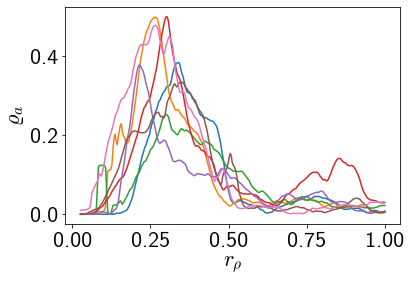

In [93]:
densImg = load_jpg('./video/')

fig, ax = plt.subplots()

for ind in np.arange(10,np.shape(densImg)[0]-5,4):
    rotated = ndimage.rotate(densImg[ind], -15)
    #plt.imshow(rotated)
    #plt.plot(255-rotated[300:600,500],'o')
    #plt.plot(200+255-rotated[300:600,512],'o')
    #plt.plot(400+255-rotated[300:600,530],'o')
    ts = 255-rotated[300:600,500];
    rPlt = np.linspace(0, 1, np.shape(ts)[0])
    smooth_data = pd.Series(ts).rolling(window=9).mean()
    ax.plot(rPlt, smooth_data/255, '-')
    
ax.set_xlabel(r'$r_\rho$')
ax.set_ylabel(r'$\varrho_a$')

#tikzplotlib.save("rhoAnt.tex")

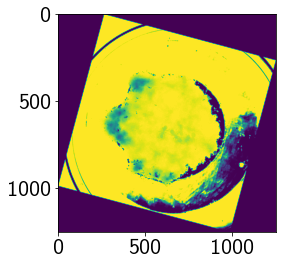

In [35]:
rotated = ndimage.rotate(densImg[20], -15)
plt.imshow(rotated)

# Orientation statistics

## Velocity tangential and normal to direction of motion

Velocity of Ants in $xy$-coordinates
$\mathbf{v} = (v_x, v_y)$ where $v_j = \Delta j f, j = x, y$ with $f$ being frequency

$\hat{\mathbf{p}} = (\cos \theta, \sin \theta)$

$\hat{\mathbf{p}}_\perp = (-\sin \theta, \cos \theta)$

$\mathbf{v}_{||} = \mathbf{v} \cdot \hat{\mathbf{p}}$

$\mathbf{v}_{\perp} = \mathbf{v} \cdot \hat{\mathbf{p}}_\perp$

Dynamics of an active Brownian particle is given by:

$\mathbf{\dot{r}}(t) = v_o \hat{\mathbf{p}}(t) + \eta(t)$

$\dot{\theta}(t) = \xi(t)$

In [38]:
# Collecting all the Ant data into a dataframe
trackFull = np.array([])
folder = './'
ll = os.listdir(folder)
ll = natsort.natsorted(ll)
for filename in ll:
    if filename.endswith(".h5"):
        with h5py.File(filename, 'r') as f:
            tracks_matrix = f['tracks'][:]
            tracks_matrix = tracks_matrix.transpose()
            #tracks_matrix = tracks_matrix[:,1,:,:]
            trackFull = np.concatenate((trackFull, tracks_matrix), axis=0) if trackFull.size else tracks_matrix
print(trackFull.shape)

# Center and Bottom locations of tte Ants
dfxC = pd.DataFrame(trackFull[:, 1, 0, :])
dfyC = pd.DataFrame(trackFull[:, 1, 1, :])
dfxC.dropna();
dfyC.dropna();

dfxB = pd.DataFrame(trackFull[:, 2, 0, :])
dfyB = pd.DataFrame(trackFull[:, 2, 1, :])
dfxB.dropna();
dfyB.dropna();

# Orientation of the Ants
dfThet = np.arctan2(dfyC-dfyB, dfxC-dfxB)
dfThet.dropna()
dfThet.shape

print(dfxB.shape)
print(dfyB.shape)

(216000, 3, 2, 12)
(216000, 12)
(216000, 12)


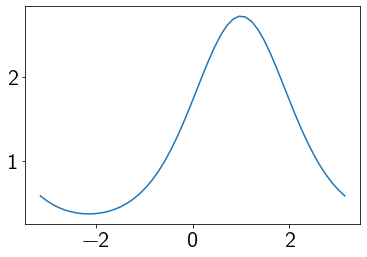

In [39]:
# Sample of von Mises distribution
nBins = 50
xT = np.linspace(-np.pi,np.pi,nBins)
yT = np.exp(np.cos(xT-1)/1.0)
plt.plot(xT, yT, '-')

In [40]:
# Fit function
def fitvMises(x, muM, sigM, amp):
    #return np.exp(-(x-muM)*(x-muM)/(2*sigM*sigM))
    return amp*np.exp(np.cos(x-muM)/sigM)

### Probability distribution of orientation as a function of time  $\mathcal{P}(\theta, t)$
#### $K(t)$ is the inverse of variance obtained by fitting $\mathcal{P}(\theta, t)$ to von Mises distribution

Text(0, 0.5, '$K(t)$')

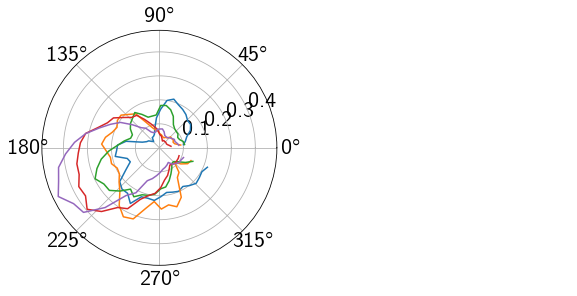

In [75]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 4]},constrained_layout=True,figsize=(8, 4))
ax[0] = plt.subplot(121, projection='polar')
# Number of divisions of the entire dataset to compute P(\theta)
nDiv = 50
tStmp = np.linspace(0, dfThet.shape[0], nDiv, dtype=int)

# Bin variable \theta
nBins = 50
binz = np.linspace(-np.pi,np.pi,nBins)

#Inverse variance
kT = np.array([])
for kInd in np.arange(0,nDiv-1):
    anG = dfThet.iloc[tStmp[kInd]:tStmp[kInd+1]][:].to_numpy().flatten()
    n, bin_edges = np.histogram(anG,bins=binz,density=True)
    nN = np.append(n[int(0.5*nBins)+1::], n[0:int(0.5*nBins)+1])

    smooth_data = pd.Series(nN).rolling(window=4).mean()
    poptaGl, pcov = curve_fit(fitvMises, binz[1::], nN, maxfev = 5000)
    #poptaGl, pcov = curve_fit(fitGauss, binz[4::], smooth_data.dropna(), maxfev = 5000)
    fitDat = fitvMises(binz,*poptaGl)
    
    if kInd%10 == 0:
        #ax[0].step(binz[0:-1],nN+0.2*kInd)
        ax[0].plot(np.pi-binz[0:-1],smooth_data)
        filename = 'orient%d.txt'%kInd
        orienDat = np.transpose([(np.pi-binz[0:-1])*180/np.pi, smooth_data])
        np.savetxt(filename,orienDat)
        #ax[0].plot(np.pi-binz,fitDat,linestyle='--',linewidth=2.0,color='black')
        #ax[0].step(binz[0:-1],smooth_data+0.2*kInd)
        #ax[0].plot(binz,fitDat+0.2*kInd,linestyle='--',linewidth=2.0,color='black')
    
    kT = np.append(kT,1/poptaGl[1])

#ax[0] = fig.add_axes([0.1,0.1,0.8,0.8],polar=True)
#ax[0].set_aspect(0.9)
#ax[0].set_xlabel(r'$\theta$')
#ax[0].set_ylabel(r'$\mathcal{P}(\theta)$')

ax[1].plot(pd.Series(kT).rolling(window=4).mean(),'bo-')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$K(t)$')

#tikzplotlib.save("orientDat.tex")

Text(0, 0.5, '$y$')

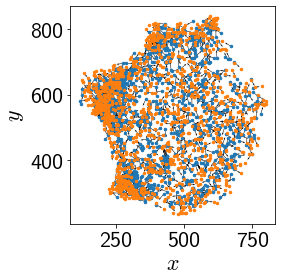

In [26]:
plt.plot(dfxB.iloc[0:-1:2000][:].to_numpy().flatten(), dfyB.iloc[0:-1:2000][:].to_numpy().flatten() ,'o', markersize=2.5)
plt.plot(dfxC.iloc[0:-1:2000][:].to_numpy().flatten(), dfyC.iloc[0:-1:2000][:].to_numpy().flatten() ,'o', markersize=2.5)
plt.quiver(dfxB.iloc[0:-1:2000][:], dfyB.iloc[0:-1:2000][:], 25*np.cos(dfThet.iloc[0:-1:2000][:]), 25*np.sin(dfThet.iloc[0:-1:2000][:]), angles='xy', scale_units='xy', scale=1)
plt.gca().set_aspect(1.2)
plt.gca().set_xlabel(r'$x$')
plt.gca().set_ylabel(r'$y$')